In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cub'
import numpy as np
import cupy as cp
from cupyx import empty_pinned
from cupyx.scipy import fft as cupyx_fft
from scipy import misc, fft as scipy_fft
from matplotlib import pyplot, cm
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display

In [2]:
cp.cuda.set_pinned_memory_allocator(None)
mempool = cp.get_default_memory_pool()

In [3]:
def compute_coordinates(res, pitch):
    """Return an array of shape (res) containing the coordinates of a sampling lattice with given pitch."""
    indices = np.arange(res, dtype=np.float32)
    return (indices - res/2 + 0.5) * pitch

def compute_edges(res, pitch):
    """Return an array of shape (res+1) containing the edges of each sampling cell."""
    indices = np.arange(res+1, dtype=np.float32)
    return (indices - res/2) * pitch

def compute_indices(x, res, pitch):
    """Return indices for given coordinates with respect to given resolution and pitch."""
    return np.floor(x / pitch + res/2).astype(np.int32)

def ab_to_r(x_a, x_b, z_r, z_a, z_b, z_f):
    """Return the coordinates on the retina corresponding to the given coordinates on planes A and B."""
    return (x_a * (1.0 - z_b/z_f) - x_b * (1.0 - z_a/z_f)) * (z_r / (z_a - z_b))

def ra_to_p(x_r, x_a, z_r, z_a, z_f):
    """Return the coordinates on the pupil corresponding to the given coordinates on plane A and on the retina."""
    return (x_a - x_r * (z_a/z_r)) * np.reciprocal(1.0 - z_a/z_f)

def take_2d(values, idx_x, idx_y):
    """Return values at the cartesian product of given indices. Out of bounds are filled with 0."""
    clipped_idx_x = np.clip(idx_x, -1, values.shape[0]) + 1
    clipped_idx_y = np.clip(idx_y, -1, values.shape[1]) + 1
    return np.pad(values, 1, mode='constant')[clipped_idx_x,][..., clipped_idx_y]

def compute_imaging_tensor(x_r, edges_a, edges_b, z_r, z_a, z_b, z_f, pupil_diameter):
    """Return the flatland imaging tensor with shape (res_r, res_a, res_b)."""
    # Project edges to the pupil plane
    edges_a_at_p = ra_to_p(x_r[..., np.newaxis, np.newaxis], edges_a, z_r, z_a, z_f)
    edges_b_at_p = ra_to_p(x_r[..., np.newaxis, np.newaxis], edges_b, z_r, z_b, z_f)
    # Bounds imposed by the pupil aperture
    lower_bound = -pupil_diameter/2
    upper_bound =  pupil_diameter/2
    # Restrict plane A edges to the pupil aperture
    edges_pa = cp.clip(edges_a_at_p, lower_bound, upper_bound)
    # Bounds imposed by the pupil aperture and plane A edges together
    lower_bound = cp.minimum(edges_pa[..., :-1, :], edges_pa[..., 1:, :])
    upper_bound = cp.maximum(edges_pa[..., :-1, :], edges_pa[..., 1:, :])
    # Restrict plane B intervals to the pupil aperture and plane A intervals
    edges_pab = cp.clip(edges_b_at_p, lower_bound, upper_bound)
    # Bounds imposed by the pupil aperture, plane A intervals and plane B intervals together
    lower_bound = cp.minimum(edges_pab[..., :-1], edges_pab[..., 1:])
    upper_bound = cp.maximum(edges_pab[..., :-1], edges_pab[..., 1:])
    # Return the lengths of the intervals normalized by the pupil diameter
    return cp.subtract(upper_bound, lower_bound) / pupil_diameter

def apply_imaging_tensor(img_tsr, signal_ab):
    """Return the image formed by the given imaging tensor over the given light field."""
    return cp.tensordot(img_tsr, signal_ab, axes=((-1, -2), (-1, -2)))

def convolution_matrix(x_in, x_out, kernel):
    """Return a convolution matrix with given kernel."""
    return kernel(x_out[..., np.newaxis] - x_in)

def sinusoidal_signal(x, frequency, phase=0.0):
    """Sample a cosine with given frequency and phase at given sampling coordinates."""
    return cp.cos((x * frequency + phase) * 2 * np.pi)/2 + 0.5

def band_signal(x, thickness):
    """Return a signal composed of a single centered band with given thickness."""
    return (cp.abs(x) < thickness) * 1.0

def decimate_lf(signal_ab, factor):
    """Return the light field decimated by the given factor."""
    return signal_ab[factor//2::factor, factor//2::factor, factor//2::factor, factor//2::factor]

def create_filter(omega_a, omega_b, z_r, z_a, z_b, z_near, z_far, xi_r, xi_p=0.0):
    """Return the filter defined from near and far focus distance and maximum frequency at the retina."""
    mask_near = (z_near * (omega_a + omega_b) - z_a * omega_a - z_b * omega_b) < 0
    mask_far = (z_far * (omega_a + omega_b) - z_a * omega_a - z_b * omega_b) > 0
    mask_depth = cp.logical_not(cp.logical_xor(mask_near, mask_far))
    mask_p_near = cp.abs((1 - z_a/z_near) * omega_a + (1 - z_b/z_near) * omega_b) < xi_p
    mask_p_far = cp.abs((1 - z_a/z_far) * omega_a + (1 - z_b/z_far) * omega_b) < xi_p
    mask_p = cp.logical_or(mask_p_near, mask_p_far)
    mask_r = cp.abs(z_a * omega_a + z_b * omega_b) < abs(z_r) * xi_r
    return cp.logical_and(mask_r, cp.logical_or(mask_depth, mask_p)) * 1.0

def tile_lf(signal_ab):
    """Return a 2-dim tiling of 2-dim images from given 4-dim light field."""
    return signal_ab.reshape(np.prod(signal_ab.shape[0:2]), -1)

def display_image(values, normalize=True, color_map=None):
    """Display an array of values as an image using a color map."""
    values = values * np.nan_to_num(1.0 / np.amax(values)) if normalize else values
    color_values = cm.get_cmap(color_map)(values, bytes=True)
    display(Image.fromarray(color_values).transpose(Image.ROTATE_90))

def rfft4(in_signal, out_spectrum, n_blocks):
    """Computes the rfftn on GPU of in_sinal and stores it in out_spectrum."""
    s0 = in_signal.shape[0]//n_blocks
    s2 = in_signal.shape[2]//n_blocks

    for i in range(n_blocks):
        out_spectrum[s0*i:s0*(i+1), ...] = cupyx_fft.rfft2(cp.asarray(in_signal[s0*i:s0*(i+1), ...]).astype(cp.float32)).get()
    cp.fft.config.get_plan_cache().clear()

    for i in range(n_blocks):
        out_spectrum[..., s2*i:s2*(i+1), :] = cupyx_fft.fft2(cp.asarray(out_spectrum[..., s2*i:s2*(i+1), :]), axes=(0, 1)).get()
    cp.fft.config.get_plan_cache().clear()

def irfft4(in_spectrum, out_signal, n_blocks):
    """Computes the irfftn on GPU of in_spectrum and stores it in out_signal."""
    s0 = in_spectrum.shape[0]//n_blocks
    s2 = in_spectrum.shape[2]//n_blocks

    for i in range(n_blocks):
        in_spectrum[..., s2*i:s2*(i+1), :] = cupyx_fft.ifft2(cp.asarray(in_spectrum[..., s2*i:s2*(i+1), :]), axes=(0, 1)).get()
    cp.fft.config.get_plan_cache().clear()

    for i in range(n_blocks):
        out_signal[s0*i:s0*(i+1), ...] = cupyx_fft.irfft2(cp.asarray(in_spectrum[s0*i:s0*(i+1), ...])).get()
    cp.fft.config.get_plan_cache().clear()

In [4]:
z_r = -17.0
z_a = 10.0
z_b = 30.0

pupil_diameter = 5.0

size_r = 5.5
size_a = size_r * z_a / abs(z_r) + pupil_diameter
size_b = size_r * z_b / abs(z_r) + pupil_diameter

res_r = 256
res_a = 120
res_b = 120

pitch_r = size_r / res_r
pitch_a = size_a / res_a
pitch_b = size_b / res_b

xi_r = 0.5 / pitch_r
xi_a = 0.5 / pitch_a
xi_b = 0.5 / pitch_b

res_A = 240
res_B = 240
pitch_A = size_a / res_A
pitch_B = size_b / res_B
xi_A = 0.5 / pitch_A
xi_B = 0.5 / pitch_B

z_f = 1000.0

In [5]:
x_r = compute_coordinates(res_r, pitch_r)
omega_r = scipy_fft.fftfreq(res_r, pitch_r)

x_a = compute_coordinates(res_a, pitch_a)[:, np.newaxis]
omega_a = scipy_fft.fftfreq(res_a, pitch_a)[:, np.newaxis].astype(np.float32)

x_b = compute_coordinates(res_b, pitch_b)[np.newaxis, :]
omega_b = scipy_fft.fftfreq(res_b, pitch_b)[np.newaxis, :].astype(np.float32)

x_A = compute_coordinates(res_A, pitch_A)[:, np.newaxis]
omega_A = scipy_fft.fftfreq(res_A, pitch_A)[:, np.newaxis].astype(np.float32)

x_B = compute_coordinates(res_B, pitch_B)[np.newaxis, :]
omega_B = scipy_fft.fftfreq(res_B, pitch_B)[np.newaxis, :].astype(np.float32)

edges_a_GPU = cp.asarray(compute_edges(res_a, pitch_a)[:, np.newaxis])
edges_b_GPU = cp.asarray(compute_edges(res_b, pitch_b)[np.newaxis, :])

Computing unsinc filter...
unsinc_filter: (240, 240, 240, 121) float16 | total size: 3.1156539916992188 GiB


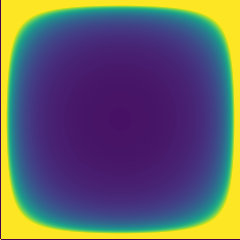

Wall time: 36.8 s


In [6]:
%%time
print('Computing unsinc filter...')

sinc_2d = np.sinc(omega_A * pitch_a) * np.sinc(omega_B * pitch_b)
sinc_4d = sinc_2d[:, :, np.newaxis, np.newaxis] * sinc_2d[np.newaxis, np.newaxis, :, :res_B//2+1]

unsinc_filter = np.clip(np.nan_to_num(np.reciprocal(sinc_4d)), -20.0, 20.0).astype(np.float16)

del sinc_2d
del sinc_4d

print('unsinc_filter:', unsinc_filter.shape, unsinc_filter.dtype, '| total size:', unsinc_filter.nbytes/2**30, 'GiB')

display_image(scipy_fft.fftshift(unsinc_filter[:, :, 0, 0]))

Computing box filter...
box_filter: (240, 240, 240, 121) bool | total size: 1.5578269958496094 GiB


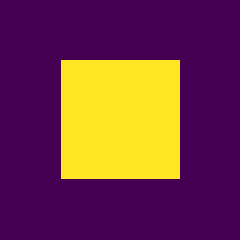

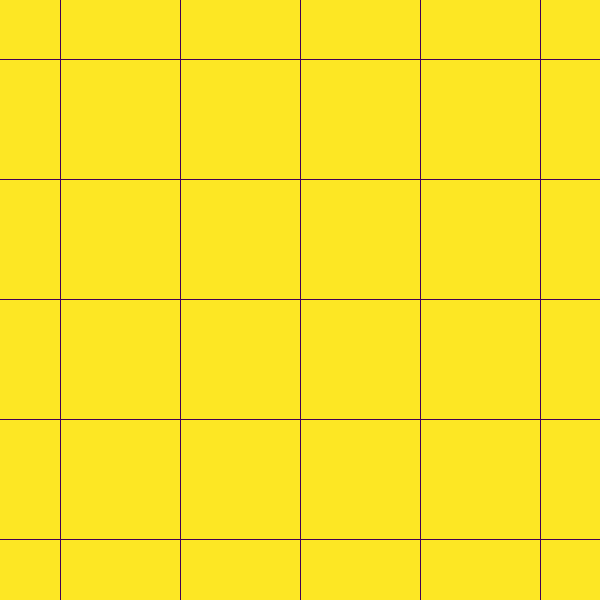

Wall time: 590 ms


In [7]:
%%time
print('Computing box filter...')

box_2d = np.logical_and(np.abs(omega_A) < xi_a, np.abs(omega_B) < xi_b)
box_filter = np.logical_and(box_2d[:, :, np.newaxis, np.newaxis], box_2d[np.newaxis, np.newaxis, :, :res_B//2+1])

del box_2d

print('box_filter:', box_filter.shape, box_filter.dtype, '| total size:', box_filter.nbytes/2**30, 'GiB')

display_image(scipy_fft.fftshift(box_filter[:, :, 0, 0]))
display_image(np.tile(np.abs(scipy_fft.fft2(scipy_fft.ifft2(box_filter[:, :, 0, 0].astype(np.complex64))[::2, ::2])), (5, 5)))

Computing awesome filter...
awesome_filter: (240, 240, 240, 121) bool | total size: 1.5578269958496094 GiB
awesome_packing (120, 120, 120, 61) float32 | total size: 0.39267539978027344 GiB | max value: 0.06250006


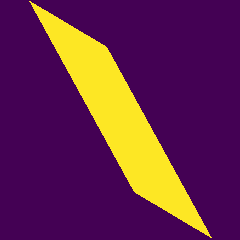

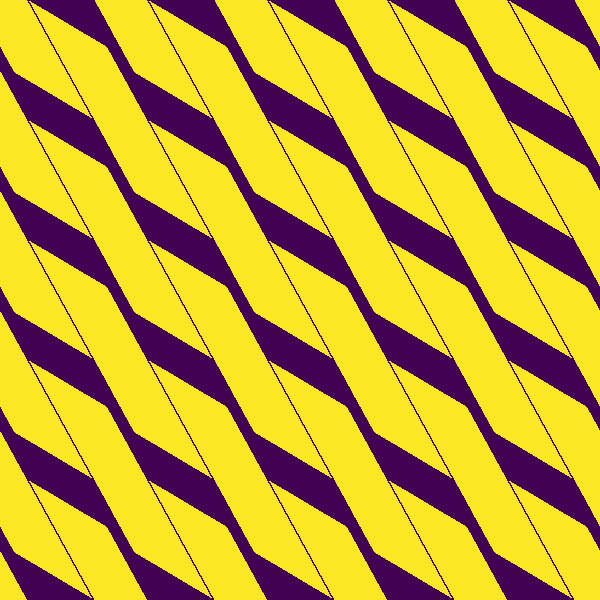

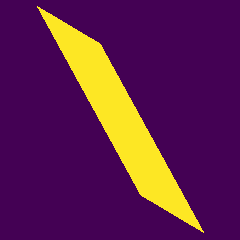

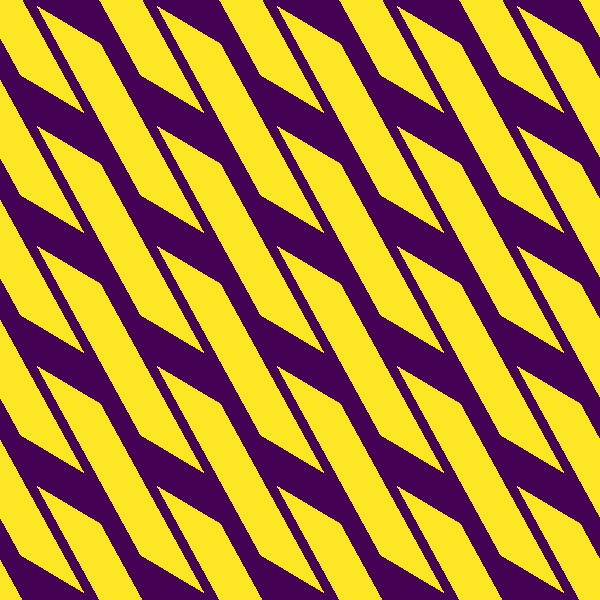

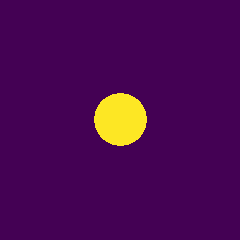

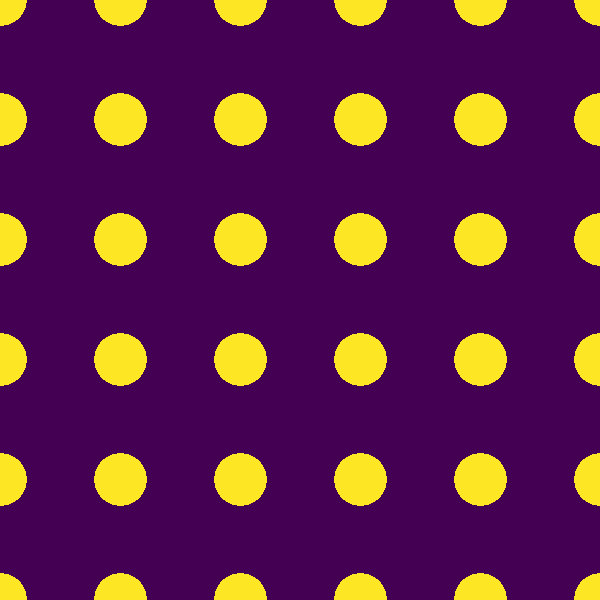

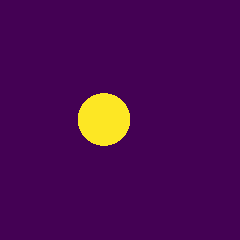

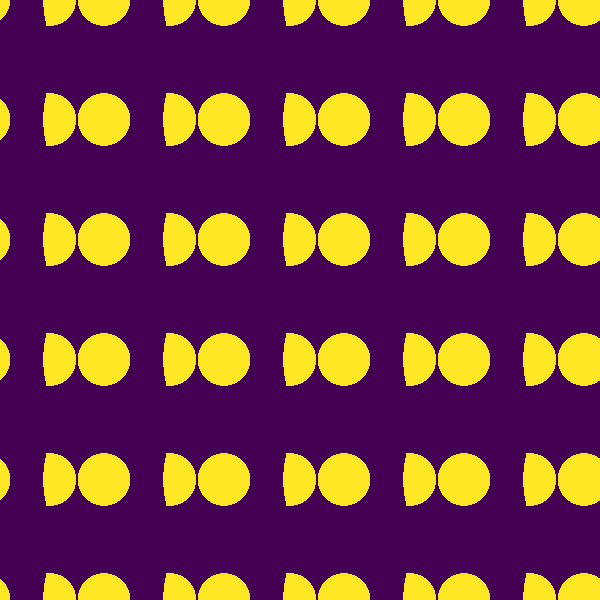

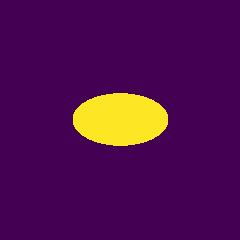

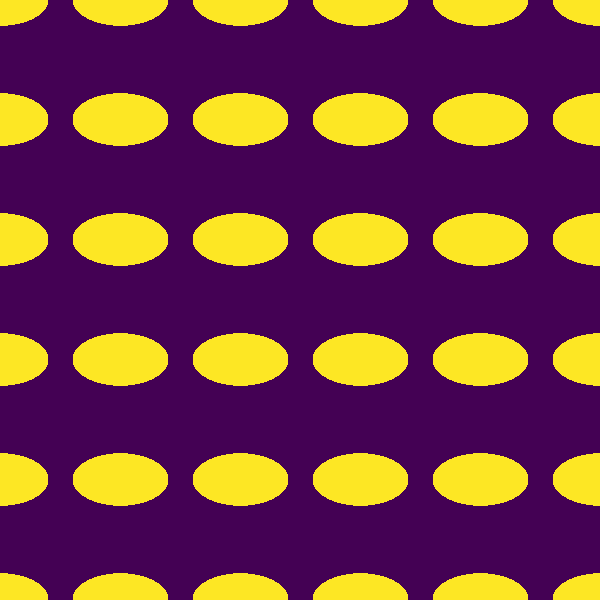

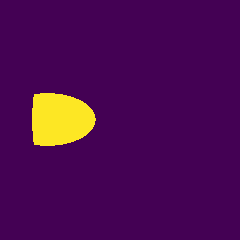

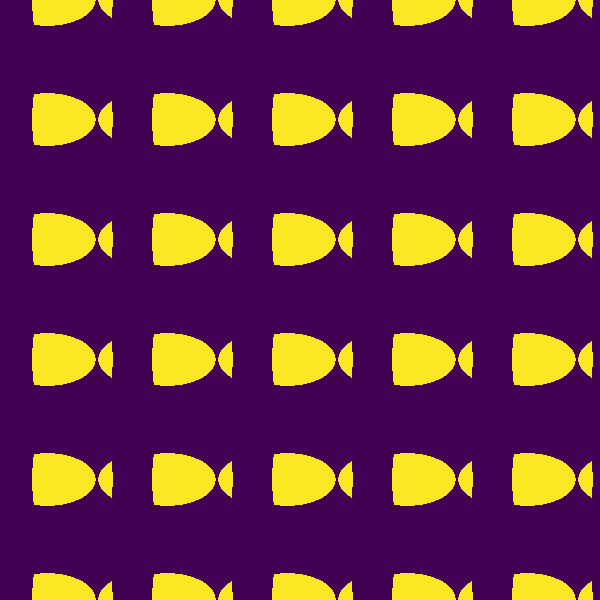

Wall time: 53.4 s


In [8]:
%%time
print('Computing awesome filter...')

sq_omega_R = np.square((z_a * omega_A + z_b * omega_B) / z_r)
sq_omega_P = np.square(((z_f - z_a) * omega_A + (z_f - z_b) * omega_B) / z_f)

disk_R = (sq_omega_R[:, :, np.newaxis, np.newaxis] + sq_omega_R[np.newaxis, np.newaxis, :, :res_B//2+1]) < 60.0
disk_P = (sq_omega_P[:, :, np.newaxis, np.newaxis] + sq_omega_P[np.newaxis, np.newaxis, :, :res_B//2+1]) < 10.0
awesome_filter = np.logical_and(disk_R, disk_P)

del sq_omega_R
del sq_omega_P
del disk_R
del disk_P

print('awesome_filter:', awesome_filter.shape, awesome_filter.dtype, '| total size:', awesome_filter.nbytes/2**30, 'GiB')

awesome_primal = np.empty((res_A, res_B, res_A, res_B), dtype=np.float32)
awesome_packing = np.empty((res_a, res_b, res_a, res_b//2+1), dtype=cp.complex64)

irfft4(awesome_filter.astype(np.complex64), awesome_primal, n_blocks=15)
rfft4(awesome_primal[::2, ::2, ::2, ::2], awesome_packing, n_blocks=15)

awesome_packing = np.abs(awesome_packing)

print('awesome_packing', awesome_packing.shape, awesome_packing.dtype, '| total size:', awesome_packing.nbytes/2**30, 'GiB | max value:', np.amax(awesome_packing))

display_image(scipy_fft.fftshift(awesome_filter[:, :, 0, 0]))
display_image(np.tile(awesome_packing[:, :, 0, 0], (5, 5)))
display_image(scipy_fft.fftshift(awesome_filter[:, :, 15, 0]))
display_image(np.tile(awesome_packing[:, :, 15, 0], (5, 5)))
display_image(scipy_fft.fftshift(awesome_filter[:, 0, :, 0]))
display_image(np.tile(awesome_packing[:, 0, :, 0], (5, 5)))
display_image(scipy_fft.fftshift(awesome_filter[:, 30, :, 0]))
display_image(np.tile(awesome_packing[:, 30, :, 0], (5, 5)))
display_image(scipy_fft.fftshift(awesome_filter[0, :, :, 0]))
display_image(np.tile(awesome_packing[0, :, :, 0], (5, 5)))
display_image(scipy_fft.fftshift(awesome_filter[40, :, :, 0]))
display_image(np.tile(awesome_packing[40, :, :, 0], (5, 5)))

del awesome_primal
del awesome_packing

scene_image: (256, 256) uint8 | total size: 6.103515625e-05 GiB


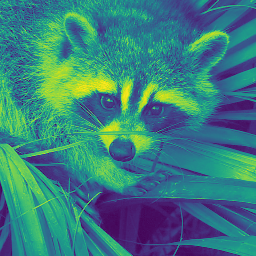

In [9]:
scene_image = misc.face(True).T[-769:-1:3, ::-3]
print('scene_image:', scene_image.shape, scene_image.dtype, '| total size:', scene_image.nbytes/2**30, 'GiB')
display_image(scene_image)

In [10]:
%%time
print('Sampling the light field signal...')

x_r_over_AB = ab_to_r(x_A, x_B, z_r, z_a, z_b, z_f)
idx_r_over_AB = compute_indices(x_r_over_AB, res_r, pitch_r)
signal_AB = take_2d(scene_image, idx_r_over_AB, idx_r_over_AB)
print('signal_AB:', signal_AB.shape, signal_AB.dtype, '| total size:', signal_AB.nbytes/2**30, 'GiB')

signal_ab = cp.asarray(signal_AB[::2, ::2, ::2, ::2].astype(np.float32))
print('signal_ab:', signal_ab.shape, signal_ab.dtype, '| total size:', signal_ab.nbytes/2**30, 'GiB')

Sampling the light field signal...
signal_AB: (240, 240, 240, 240) uint8 | total size: 3.08990478515625 GiB
signal_ab: (120, 120, 120, 120) float32 | total size: 0.7724761962890625 GiB
Wall time: 10.9 s


In [11]:
%%time
print('Allocating host memory...')

filtered_signal = np.empty((res_A, res_B, res_A, res_B), dtype=cp.float32)
spectrum_AB = np.empty((res_A, res_B, res_A, res_B//2+1), dtype=cp.complex64)

Allocating host memory...
Wall time: 0 ns


In [12]:
%%time
print('Computing the light field spectrum...')

rfft4(signal_AB, spectrum_AB, n_blocks=15)

print('spectrum_AB:', spectrum_AB.shape, spectrum_AB.dtype, '| total size:', spectrum_AB.nbytes/2**30, 'GiB')

Computing the light field spectrum...
spectrum_AB: (240, 240, 240, 121) complex64 | total size: 12.462615966796875 GiB
Wall time: 1min 26s


In [13]:
%%time
print('Computing box filtered light field...')

np.multiply(spectrum_AB, box_filter, out=spectrum_AB)
irfft4(spectrum_AB, filtered_signal, n_blocks=15)
box_ab = cp.asarray(filtered_signal[::2, ::2, ::2, ::2])
print('box_ab:', box_ab.shape, box_ab.dtype, '| total size:', box_ab.nbytes/2**30, 'GiB')

np.multiply(spectrum_AB, unsinc_filter, out=spectrum_AB)
irfft4(spectrum_AB, filtered_signal, n_blocks=15)
unsinc_box_ab = cp.asarray(filtered_signal[::2, ::2, ::2, ::2])
print('unsinc_box_ab:', unsinc_box_ab.shape, unsinc_box_ab.dtype, '| total size:', unsinc_box_ab.nbytes/2**30, 'GiB')

del box_filter

Computing box filtered light field...
box_ab: (120, 120, 120, 120) float32 | total size: 0.7724761962890625 GiB
unsinc_box_ab: (120, 120, 120, 120) float32 | total size: 0.7724761962890625 GiB
Wall time: 2min 22s


In [14]:
%%time
print('Computing the light field spectrum (again)...')

rfft4(signal_AB, spectrum_AB, n_blocks=15)

print('spectrum_AB:', spectrum_AB.shape, spectrum_AB.dtype, '| total size:', spectrum_AB.nbytes/2**30, 'GiB')

Computing the light field spectrum (again)...
spectrum_AB: (240, 240, 240, 121) complex64 | total size: 12.462615966796875 GiB
Wall time: 1min 25s


In [15]:
%%time
print('Computing awesome filtered light field...')

np.multiply(spectrum_AB, awesome_filter, out=spectrum_AB)
irfft4(spectrum_AB, filtered_signal, n_blocks=15)
awesome_ab = cp.asarray(filtered_signal[::2, ::2, ::2, ::2])
print('awesome_ab:', awesome_ab.shape, awesome_ab.dtype, '| total size:', awesome_ab.nbytes/2**30, 'GiB')

np.multiply(spectrum_AB, unsinc_filter, out=spectrum_AB)
irfft4(spectrum_AB, filtered_signal, n_blocks=15)
unsinc_awesome_ab = cp.asarray(filtered_signal[::2, ::2, ::2, ::2])
print('unsinc_awesome_ab:', unsinc_awesome_ab.shape, unsinc_awesome_ab.dtype, '| total size:', unsinc_awesome_ab.nbytes/2**30, 'GiB')

del awesome_filter
del unsinc_filter
del spectrum_AB
del filtered_signal

Computing awesome filtered light field...
awesome_ab: (120, 120, 120, 120) float32 | total size: 0.7724761962890625 GiB
unsinc_awesome_ab: (120, 120, 120, 120) float32 | total size: 0.7724761962890625 GiB
Wall time: 3min 13s


Computing retinal images...


  0%|          | 0/65536 [00:00<?, ?it/s]

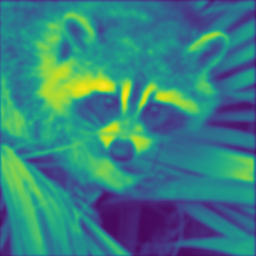

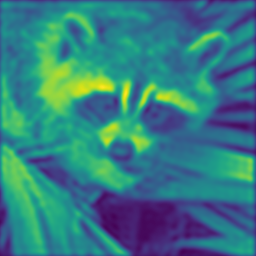

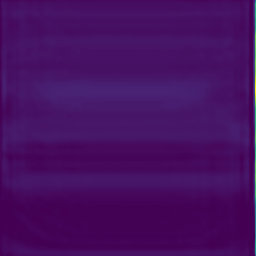

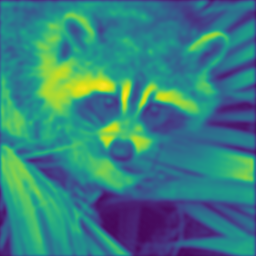

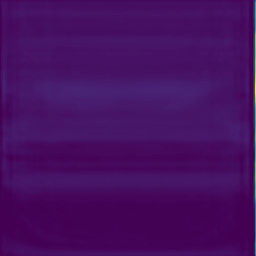

Wall time: 1h 42min 50s


In [16]:
%%time
print('Computing retinal images...')

retinal_image = np.zeros((res_r, res_r), dtype=np.float32)
box_image = np.zeros((res_r, res_r), dtype=np.float32)
unsinc_box_image = np.zeros((res_r, res_r), dtype=np.float32)
awesome_image = np.zeros((res_r, res_r), dtype=np.float32)
unsinc_awesome_image = np.zeros((res_r, res_r), dtype=np.float32)

for idx_r in tqdm(np.ndindex((res_r, res_r)), total=res_r**2, leave=False):
    img_tsr = compute_imaging_tensor(cp.asarray(x_r[idx_r,]), edges_a_GPU, edges_b_GPU, z_r, z_a, z_b, z_f, pupil_diameter).astype(cp.float32)
    img_tsr = img_tsr[0, ..., np.newaxis, np.newaxis] * img_tsr[1, np.newaxis, np.newaxis, ...]
    retinal_image[idx_r] = cp.sum(signal_ab * img_tsr)
    box_image[idx_r] = cp.sum(box_ab * img_tsr)
    unsinc_box_image[idx_r] = cp.sum(unsinc_box_ab * img_tsr)
    awesome_image[idx_r] = cp.sum(awesome_ab * img_tsr)
    unsinc_awesome_image[idx_r] = cp.sum(unsinc_awesome_ab * img_tsr)

display_image(retinal_image)
display_image(box_image)
display_image(unsinc_box_image)
display_image(awesome_image)
display_image(unsinc_awesome_image)